Genetic Algorithms(GAs) are adaptive heuristic search algorithms that belong to the larger part of evolutionary algorithms. Genetic algorithms are based on the ideas of natural selection and genetics. These are intelligent exploitation of random search provided with historical data to direct the search into the region of better performance in solution space. They are commonly used to generate high-quality solutions for optimization problems and search problems.

Genetic algorithms simulate the process of natural selection which means those species who can adapt to changes in their environment are able to survive and reproduce and go to next generation. In simple words, they simulate “survival of the fittest” among individual of consecutive generation for solving a problem.

In [ ]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from keras.callbacks import EarlyStopping, TensorBoard
from keras.layers import Dense
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm
import numpy as np
import random
import pickle as pkl

import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Load the dataset
dataset = pd.read_csv('mushrooms.csv')

# Separate the target variable from the features
y_train = dataset['class']
x_train = dataset.drop(labels=['class'], axis=1)

# Encode categorical features using LabelEncoder
le = LabelEncoder()
cols = x_train.columns.values
for col in cols:
    x_train[col] = le.fit_transform(x_train[col])

# Encode the target variable 'class' using LabelEncoder
y_train = le.fit_transform(y_train)

# Perform One-Hot Encoding for the categorical features
ohe = OneHotEncoder(sparse=False)  # Set sparse=False to get a numpy array directly
x_train = ohe.fit_transform(x_train)

# Scale the features using StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)

# Split the dataset into training, testing, and validation sets
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.30, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.50, random_state=42)


In [ ]:
# Artificial Neural Network Implementation
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def forward(x, w, activation):
    return activation(np.matmul(x, w))

def accuracy_fn(y, y_hat):
    return (np.where(y == y_hat)[0].size / y_hat.size)

def predict(x, y_hat, weights, activation):
    predictions = np.zeros(shape=(x.shape[0]))

    for idx in range(x.shape[0]):
        r1 = x[idx, :]
        for curr_weights in weights:
            r1 = forward(r1, curr_weights, activation)
        predictions[idx] = np.where(r1 == np.max(r1))[0][0]

    accuracy = accuracy_fn(predictions, y_hat)
    return accuracy, predictions

def fitness(x, y_hat, weights, activation):
    accuracy = np.empty(shape=(weights.shape[0]))
    for idx in range(weights.shape[0]):
        accuracy[idx], _ = predict(x, y_hat, weights[idx, :], activation)
    return accuracy

In [ ]:
# Vector-Matrix Manipulations
def mat_to_vector(mat_pop_weights):
    weights_vector = []
    for idx in range(mat_pop_weights.shape[0]):
        curr_vector = []
        for layer_idx in range(mat_pop_weights.shape[1]):
            vector_weights = np.reshape(mat_pop_weights[idx, layer_idx], newshape=(mat_pop_weights[idx, layer_idx].size))
            curr_vector.extend(vector_weights)
        weights_vector.append(curr_vector)
    return np.array(weights_vector)


def vector_to_mat(vector_weights, mat_pop_weights):
    mat_weights = []
    for idx in range(mat_pop_weights.shape[0]):
        start = 0
        end = 0
        for layer_idx in range(mat_pop_weights.shape[1]):
            end = end + mat_pop_weights[idx, layer_idx].size
            curr_vector = vector_weights[idx, start:end]
            mat_layer_weights = np.reshape(curr_vector, newshape=(mat_pop_weights[idx, layer_idx].shape))
            mat_weights.append(mat_layer_weights)
            start = end
    return np.reshape(mat_weights, newshape=mat_pop_weights.shape)

In [ ]:
# Genetic Algorithm Implementation
def mating_pool(pop, fitness, num_parents):
    parents = np.empty((num_parents, pop.shape[1]))
    for parent_num in range(num_parents):
        max_fitness_idx = np.where(fitness == np.max(fitness))
        max_fitness_idx = max_fitness_idx[0][0]
        parents[parent_num, :] = pop[max_fitness_idx, :]
        fitness[max_fitness_idx] = -99
    return parents


def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size)
    crossover_point = np.uint32(offspring_size[1]/2)

    for k in range(offspring_size[0]):

        parent1_idx = k%parents.shape[0]
        parent2_idx = (k+1)%parents.shape[0]

        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]

    return offspring


def mutation(offspring_crossover, mutation_percent):
    num_mutations = np.uint32((mutation_percent*offspring_crossover.shape[1]))
    mutation_indices = np.array(random.sample(range(0, offspring_crossover.shape[1]), num_mutations))

    for idx in range(offspring_crossover.shape[0]):
        random_value = np.random.uniform(-1.0, 1.0, 1)
        offspring_crossover[idx, mutation_indices] = offspring_crossover[idx, mutation_indices] + random_value

    return offspring_crossover

In [ ]:
# Parameters
solution_per_population = 8
num_parents_mating = 4
num_generations = 100
mutation_percent = 0.20

In [ ]:
input_shape = x_train.shape[1]
output_shape = len(np.unique(y_train))

In [ ]:
# Initial weights
initial_weights = []
for curr_sol in np.arange(0, solution_per_population):

    w1 = np.random.uniform(low=-0.1, high=0.1, size=(input_shape, 128))
    w2 = np.random.uniform(low=-0.1, high=0.1, size=(128, 64))
    w3 = np.random.uniform(low=-0.1, high=0.1,size=(64, output_shape))

    initial_weights.append(np.array([w1, w2, w3]))

In [ ]:
weights_mat = np.array(initial_weights)
weights_vector = mat_to_vector(weights_mat)

best_outputs = []
accuracies = np.empty(shape=(num_generations))

In [ ]:
# Training
for generation in tqdm(range(num_generations)):

    # vector to matrix
    weights_mat = vector_to_mat(weights_vector, weights_mat)

    # fitness of the population
    fit = fitness(x_train, y_train, weights_mat, activation=sigmoid)

    # assign first fitness to the array
    accuracies[generation] = fit[0]

    # selecting mating parents from pool
    parents = mating_pool(weights_vector, fit.copy(), num_parents_mating)

    # generate new population using crossover
    offspring_crossover = crossover(parents, offspring_size=(weights_vector.shape[0]-parents.shape[0], weights_vector.shape[1]))

    # adding mutation to the population
    offspring_mutation = mutation(offspring_crossover, mutation_percent=mutation_percent)

    # new population combining parents of crossver and mut
    weights_vector[0:parents.shape[0], :] = parents
    weights_vector[parents.shape[0]:, :] = offspring_mutation


100%|██████████| 100/100 [04:10<00:00,  2.51s/it]


In [ ]:
# Analysis
weights_mat = vector_to_mat(weights_vector, weights_mat)
best_weights = weights_mat [0, :]
acc, predictions = predict(x_train, y_train, best_weights, sigmoid)
print("Accuracy of the best solution is : ", acc)

Accuracy of the best solution is :  0.8227224762574745


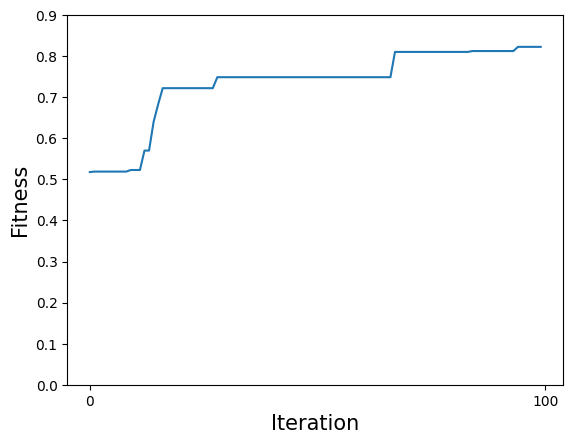

In [ ]:
plt.plot(accuracies)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Fitness", fontsize=15)
plt.xticks(np.arange(0, num_generations+1, 100))
plt.yticks(np.arange(0, 1, 0.1))
plt.show()

In [ ]:
# Test predictions
weights_mat = vector_to_mat(weights_vector, weights_mat)
best_weights = weights_mat [0, :]
acc, predictions = predict(x_test, y_test, best_weights, sigmoid)
print("Accuracy of the best solution is : ", acc)

Accuracy of the best solution is :  0.8162428219852338
